In [1]:
using Plots
default(fmt=:png, dpi=300)

# Julia's Data-Type Magic: Autodifferentiation in 4 lines
([Back to Overview](../index.html#/0/5))

Take as an example the babylonian algorithm to calculate $\sqrt{x}$
> Repeat $ t \leftarrow  \frac{t+\frac{x}{t}}{2} $ until $t$ converges to $\sqrt{x}$.

For illustration we will use 10 iterations

In [2]:
function babylonian(x; N::Integer = 10) 
    t = (1+x)/2
    for i = 2:N
        t = (t + x/t)/2 
    end    
    t
end

babylonian (generic function with 1 method)

Check: `sqrt(100) == 10`

In [3]:
babylonian(100)

10.0

In [4]:
x=2; babylonian(x), √x  # Type \sqrt+<tab> to get the symbol

(1.414213562373095, 1.4142135623730951)

Let's look at the convergence behaviour

In [5]:
x = range(0.01, 10, length=100)
y = [babylonian(x, N = N) for x = x, N = 1:5]
plot(x, y[:, 1], label="N=1")
for i=2:5
    plot!(x, y[:, i], label="N=$(i)")
end;

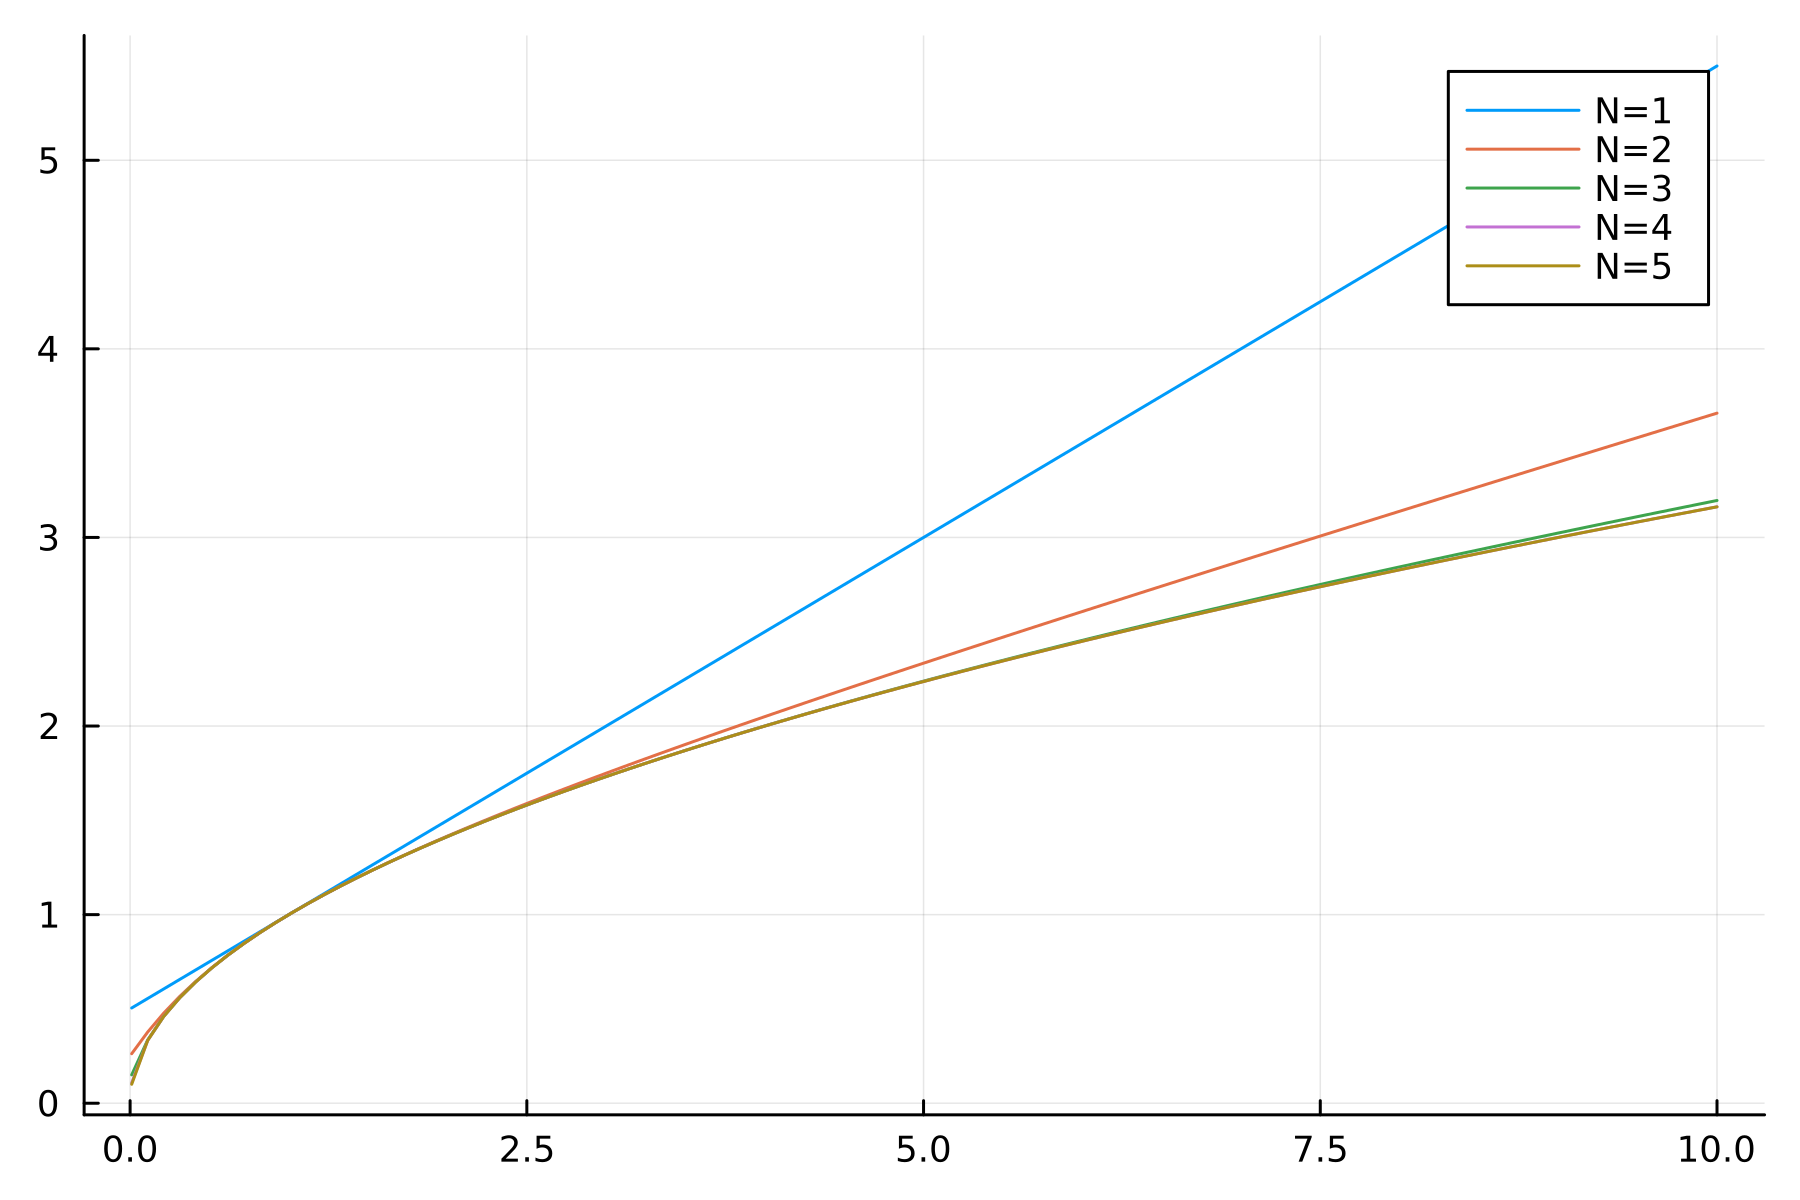

In [6]:
plot!()

### ... and now the derivative almost by magic

Define a dual type -- a mathematical object that's a function-derivative pair

In [7]:
struct D <: Number
    f::Tuple{Float64,Float64}
end

The first element follows the normal rules of arithmetic. But the second element implements:
* Sum Rule: $(x+y)' = x' + y'$
* Quotient Rule: $(\frac{x}{y})' = \frac{yx'-xy'}{y^2}$

In [8]:
import Base: +, -, *, /, convert, promote_rule
+(x::D, y::D) = D(x.f .+ y.f)
-(x::D, y::D) = D(x.f .- y.f)
*(x::D, y::D) = D((x.f[1]*y.f[1], (x.f[2]*y.f[1] + x.f[1]*y.f[2])))
/(x::D, y::D) = D((x.f[1]/y.f[1], (y.f[1]*x.f[2] - x.f[1]*y.f[2])/y.f[1]^2))
convert(::Type{D}, x::Real) = D((x,zero(x)))
promote_rule(::Type{D}, ::Type{<:Number}) = D

promote_rule (generic function with 145 methods)

Let's compute the derivative of $\sqrt{x}$ at $x=25$

We start withe the dual of `(25, 1)`

In [9]:
x = 25
x̂ = D((x, 1))

D((25.0, 1.0))

We know (because we're smart!) that the derivative of $\sqrt{x}$ is $\frac{1}{2\sqrt{x}}$ => therefore the result that we expect is:

In [10]:
(√x, .5/√x)

(5.0, 0.1)

Now let's pass the dual to the babylonian algorithm:

In [11]:
babylonian(x̂)

D((5.0, 0.1))

Because Julia's addition, subtraction, multiplication, and division operators "know" what to do with the `D` data type, we automatically "propagate" the derivative as we perform the regular arithmatic.